# Real-time simulation of Schwinger model

Working in the Fock basis, integrate the Schroedinger equation of a colliding particle-antiparticle pair.

In [1]:
import sys
sys.path.append('/home/iiyama/src/qt4hep')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.experimental.sparse as jsparse
from jax.experimental.sparse import BCOO
from qiskit.quantum_info import SparsePauliOp

jax.config.update('jax_enable_x64', True)

from qt4hep.staggered_fermion import *
from qt4hep.dense import *
from qt4hep.schwinger import *

In [2]:
num_sites = 12
half_lat = num_sites // 2
hdim = 2 ** num_sites
mass = 1.
lsp = 0.5
l0 = 0

In [3]:
rapidity, wavenumber = get_rapidity(num_sites, lsp, mass, with_wn=True)
momentum = mass * np.sinh(rapidity)
energy = mass * np.cosh(rapidity)

## Hamiltonian


In [4]:
half_lat = num_sites // 2
hdim = 2 ** num_sites
rapidity, wavenumber = get_rapidity(num_sites, lsp, mass, with_wn=True)

print('Identifying Fock-space physical state indices')
fock_config = (jnp.arange(hdim)[:, None] >> jnp.arange(num_sites)[None, :]) % 2
sign = jnp.repeat(np.array([1, -1]), half_lat)
charge = jnp.sum(fock_config * sign[None, :], axis=1)
fock_indices = np.nonzero(charge == 0)[0]
subdim = fock_indices.shape[0]

print('Free Hamiltonian')
occupancy = fock_config[fock_indices]
energy = mass * np.cosh(rapidity)
energy = np.tile(energy, 2)
h_free = np.sum(energy[None, :] * occupancy, axis=1)

print('Identifying position-space physical state indices')
fermion_config = fock_config.copy()
total_excitations = jnp.sum(fermion_config, axis=1)
pos_indices = np.nonzero(total_excitations == half_lat)[0]

print('Constructing position-space number operators')
fock_ab = [op.to_matrix(sparse=True) for op in jw_annihilator_spo(num_sites)]
phi = ab_to_phi_sparse(fock_ab, rapidity, wavenumber)
fermi_num_coords = []
fermi_num_data = []
for op in phi:
    op = op[:, fock_indices]
    arr = coo_array(dagger(op) @ op)
    fermi_num_coords.append(np.array(arr.coords).T)
    fermi_num_data.append(arr.data)
fermi_num = BCOO((jnp.array(fermi_num_data), jnp.array(fermi_num_coords)),
                    shape=(num_sites, subdim, subdim))
print('Computing basis change matrix')
basis_change_mat = position_states_as_fock_state_sums(pos_indices, fermi_num)

Identifying Fock-space physical state indices
Free Hamiltonian
Identifying position-space physical state indices
Constructing position-space number operators
Computing basis change matrix


In [4]:
start = time.time()
fock_indices, pos_indices, fermi_num, basis_change_mat, h_free, h_elec = setup(num_sites, lsp, mass, l0)
print(time.time() - start)

Identifying Fock-space physical state indices


Free Hamiltonian
Identifying position-space physical state indices
Constructing position-space number operators
Computing basis change matrix
Computing the electric Hamiltonian
31.38702082633972


In [ ]:
import h5py
with h5py.File('/tmp/iv.h5', 'w') as out:
    out.create_dataset('basis_change_mat', data=basis_change_mat)
    out.create_dataset('h_elec', data=h_elec)

In [6]:
fermi_num = np.array(fermi_num.todense())

In [14]:
pos_indices[1]

Array(95, dtype=int64)

In [9]:
basis_change_mat = cleaned(basis_change_mat)

In [18]:
icol = 1
col = basis_change_mat[:, icol]
for isite in range(12):
    if (pos_indices[icol] >> isite) % 2:
        print(np.allclose(fermi_num[isite] @ col - col, 0.))
    else:
        print(np.allclose(fermi_num[isite] @ col, 0.))


False
False
False
False
False
False
False
False
False
False
False
False


In [23]:
basis_change_mat[:, 0]

array([ 1.77975864e-05+5.11248354e-19j,  2.29512350e-03+3.77394240e-17j,
       -1.78721745e-03-1.03185048e-03j,  7.78370710e-04+1.34817762e-03j,
        2.08424977e-17-1.26375358e-03j, -7.78370710e-04+1.34817762e-03j,
        1.78721745e-03-1.03185048e-03j,  2.06370095e-03+3.29871517e-17j,
       -1.52218004e-03-8.78831057e-04j,  5.71266233e-04+1.14824811e-03j,
        1.46699109e-04-1.07634383e-03j, -8.46291604e-04+1.14824811e-03j,
        1.70184902e-03-8.78831057e-04j, -1.09391892e-02-6.31574382e-03j,
        1.65863962e-02+8.25191697e-03j, -9.20593261e-03-5.31504767e-03j,
       -1.89178784e-02-7.73517485e-03j,  1.47313913e-02+8.50517272e-03j,
       -6.41583009e-03-4.60296631e-03j,  1.88800530e-02+8.25191697e-03j,
       -1.84118652e-02-1.06300953e-02j,  1.20281306e-02+6.94444444e-03j,
       -6.41583009e-03-1.90661107e-03j, -1.22303853e-02-6.31574382e-03j,
        1.80421959e-02+1.04166667e-02j, -1.70636876e-02-8.29498321e-03j,
        1.47313913e-02+4.25258636e-03j, -1.05541102

In [22]:
basis_change_mat[:, 1]

array([ 6.07647607e-05-4.62836362e-19j,  7.83604179e-03+2.67900577e-17j,
       -6.10194206e-03-3.52295789e-03j,  2.65752384e-03+4.60296631e-03j,
        1.84673658e-17-4.31472461e-03j, -2.65752384e-03+4.60296631e-03j,
        6.10194206e-03-3.52295789e-03j,  7.04591578e-03+2.09679203e-17j,
       -5.55638571e-03-3.20798078e-03j,  2.41992260e-03+4.19142889e-03j,
        6.07647607e-05-3.92895801e-03j, -2.41992260e-03+4.19142889e-03j,
        5.45113806e-03-3.20798078e-03j,  8.99042093e-03+5.19062194e-03j,
       -3.91551701e-03-6.78187440e-03j,  0.00000000e+00+0.00000000e+00j,
       -7.83604179e-03+6.35718761e-03j,  6.10194206e-03+3.52295789e-03j,
       -2.65752384e-03-4.60296631e-03j,  3.91551701e-03-6.78187440e-03j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
       -2.65752384e-03+4.60296631e-03j,  4.58200158e-03+5.19062194e-03j,
       -1.05688737e-02-6.10194206e-03j,  4.60296631e-03+7.97257151e-03j,
        6.10194206e-03-1.09962801e-02j, -4.60296631

In [20]:
np.allclose(basis_change_mat.conjugate().T @ basis_change_mat, np.eye(924, dtype=complex))

False

In [6]:
fock_index = np.sum((np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]) << np.arange(12)))

In [8]:
np.nonzero(fock_indices == fock_index)

(array([463]),)

In [9]:
h_free[463]

4.0

In [11]:
h_elec[:, 463]

array([ 7.37171423e-01+1.73478967e-01j, -1.15829777e+00+1.57868933e-01j,
        4.94109328e-01-3.32029119e-01j, -5.68475452e-01-3.41557976e-01j,
       -3.00284554e-01+1.60722243e-01j, -6.15057397e-02+2.41916398e-01j,
        2.04987181e-01+2.31982576e-01j,  6.15328179e-02+3.03396394e-01j,
        7.70165262e-02-1.43377304e-01j, -2.32337760e-01+2.97804946e-01j,
        8.41969143e-02+1.87500000e-01j,  1.36666902e-01+3.22207641e-02j,
        2.43055556e-01-9.62250449e-02j,  5.59016994e-02-5.37914354e-02j,
        0.00000000e+00+0.00000000e+00j,  9.04555925e-02-5.61551642e-02j,
        0.00000000e+00+0.00000000e+00j, -5.95452435e-02-9.27930304e-02j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
       -1.20404172e-01+5.67052149e-02j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        5.99348359e-02+1.04495342e-02j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000

In [23]:
h_free[np.sum(np.array([1] + [0] * (num_sites - 2)))]

array([-1.96961551, -1.96961551, -1.73205081, -1.28557522, -0.68404029,
        0.        ,  0.68404029,  1.28557522,  1.73205081])

## Time evolution

In [6]:
@jax.jit
def dpsidt(y, _, hamiltonian):
    return -1.j * hamiltonian @ y

In [7]:
num_sites = 4
spmat = schwinger_hamiltonian(num_sites, 0., 1., 1.).to_matrix(sparse=True)
bcoo = BCOO.from_scipy_sparse(spmat)

In [36]:
initial_state = np.zeros((2,) * num_sites, dtype=np.complex128)
initial_state[(0, 1) * (num_sites // 2)] = 1.
initial_state = initial_state.reshape(-1)


In [37]:
tlist = np.linspace(0., np.pi / 2., 100)
yvals = odeint(dpsidt, initial_state, tlist, bcoo)

In [38]:
yvals = np.array(yvals)
densities = 0.
for isite in range(num_sites):
    op = np.zeros((2,) * num_sites)
    op += (1 - 2 * (isite % 2)) * np.array([1., -1.])
    op = np.moveaxis(op, -1, num_sites - isite - 1).reshape(-1)
    densities += np.einsum('ti,i,ti->t', yvals.conjugate(), op, yvals).real
densities += num_sites
densities /= 2. * num_sites

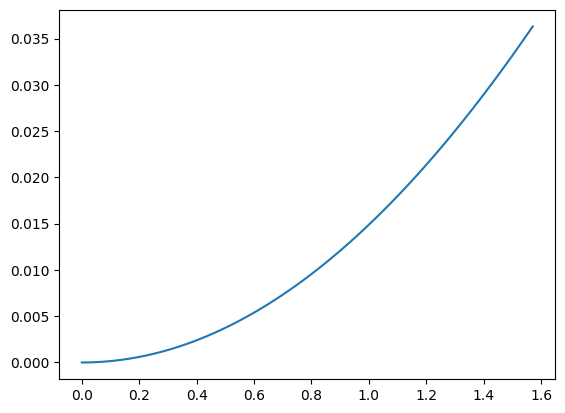

In [39]:
plt.plot(tlist, densities)

## Checking subspace dimension scaling

In [5]:
ns = np.arange(2, 24, 2)
subdims = []
for n in ns:
    subdim = np.prod(np.arange(n // 2, n) + 1) / np.prod(np.arange(n // 2) + 1)
    subdims.append(subdim)
subdims = np.array(subdims)

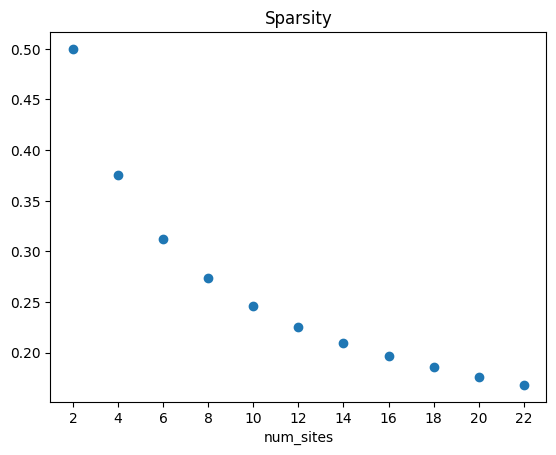

In [6]:
plt.scatter(ns, subdims / (2 ** ns))
plt.title('Sparsity')
plt.xlabel('num_sites')
plt.xticks(ns, labels=[f'{n}' for n in ns]);

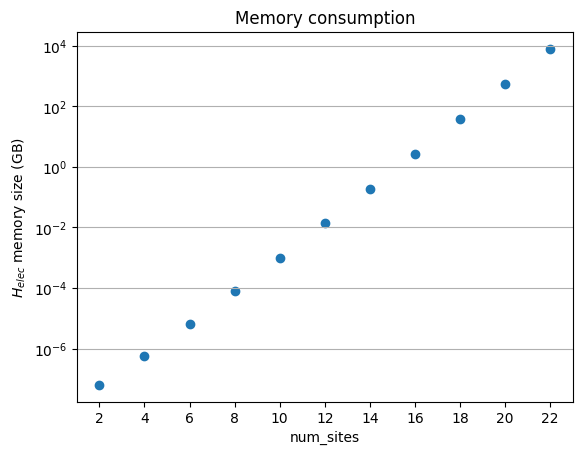

In [7]:
plt.scatter(ns, np.square(subdims) * 16 * 1.e-9)
plt.title('Memory consumption')
plt.xlabel('num_sites')
plt.ylabel('$H_{elec}$ memory size (GB)')
plt.yscale('log')
plt.grid(axis='y')
plt.xticks(ns, labels=[f'{n}' for n in ns]);